In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

## Load data

In [ ]:
# Loading MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Dim x_train:", x_train.shape)
print("Dim y_train:", y_train.shape)
print("Dim x_test:", x_test.shape)
print("Dim y_test:", y_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
Dim x_train: (60000, 28, 28)
Dim y_train: (60000,)
Dim x_test: (10000, 28, 28)
Dim y_test: (10000,)


In [ ]:
x_train[0][5]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
        18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
         0,   0], dtype=uint8)

In [ ]:
x_train_n = x_train / 255 # normalization
x_test_n = x_test / 255
x_train_n[0][5]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.01176471, 0.07058824, 0.07058824,
       0.07058824, 0.49411765, 0.53333333, 0.68627451, 0.10196078,
       0.65098039, 1.        , 0.96862745, 0.49803922, 0.        ,
       0.        , 0.        , 0.        ])

In [ ]:
np.random.seed(42)
# normal (Gaussian) distribution
# this cell is just for visualizing the images. After, images will be reshape into a vector
ruido = np.random.normal(loc=0, scale=0.6, size=x_train_n.shape)

x_train_nn = x_train_n + ruido
x_train_nn = np.clip(x_train_nn, 0, 1)

ruido = np.random.normal(loc=0, scale=0.6, size=x_test_n.shape)

x_test_nn = x_test_n + ruido
x_test_nn = np.clip(x_test_nn, 0, 1)

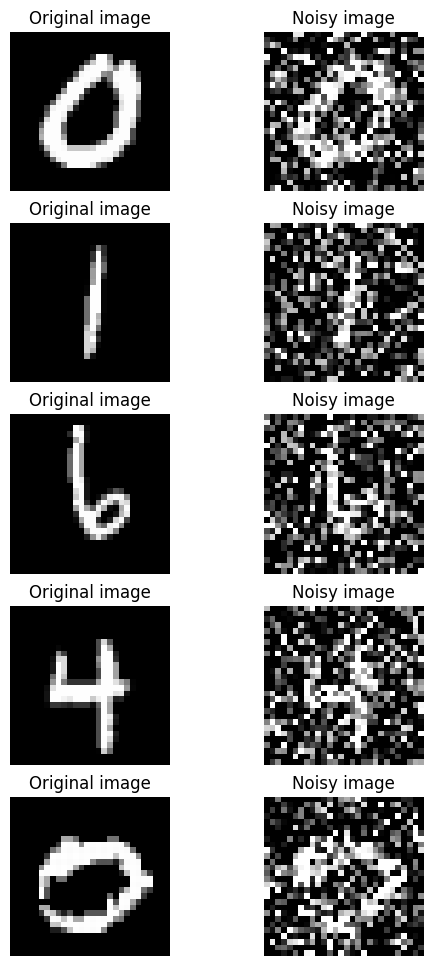

In [ ]:
sample_index = np.array(([8730, 3281, 2994, 1599, 5450]))

fig, axs = plt.subplots(len(sample_index), 2, figsize=(6,12))

for i,index in enumerate(sample_index):
  axs[i,0].imshow(x_test_n[index],cmap='gray')
  axs[i,0].axis('off')
  axs[i,0].set_title('Original image')

  axs[i,1].imshow(x_test_nn[index],cmap='gray')
  axs[i,1].axis('off')
  axs[i,1].set_title('Noisy image')

### Reshape para trabajar con capas densas

In [ ]:
x_train_r = tf.reshape(x_train_n, (x_train_n.shape[0], -1)) # reshape to 1-D
x_test_r = tf.reshape(x_test_n, (x_test_n.shape[0], -1))

In [ ]:
np.random.seed(42)

ruido = np.random.normal(loc=0, scale=0.6, size=x_train_r.shape)

x_train_r_n = x_train_r + ruido
x_train_r_n = np.clip(x_train_r_n, 0, 1)

ruido = np.random.normal(loc=0, scale=0.6, size=x_test_r.shape)

x_test_r_n = x_test_r + ruido
x_test_r_n = np.clip(x_test_r_n, 0, 1)

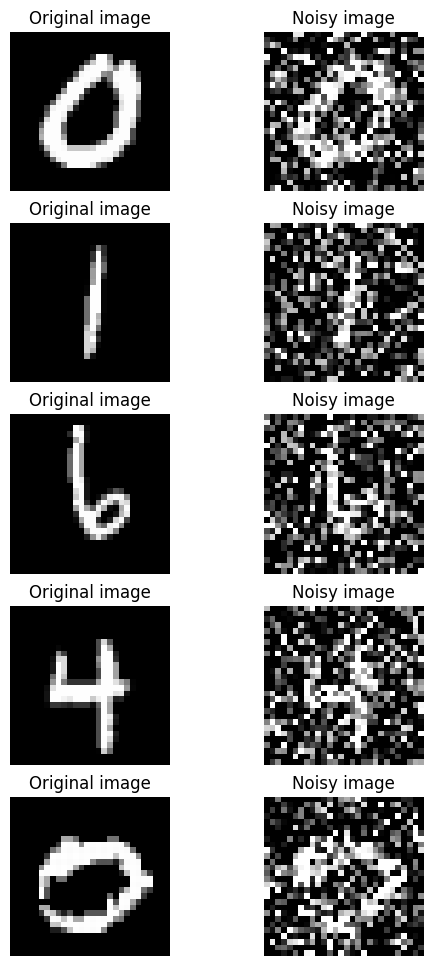

In [ ]:
sample_index = np.array(([8730, 3281, 2994, 1599, 5450]))

fig, axs = plt.subplots(len(sample_index), 2, figsize=(6,12))

for i,index in enumerate(sample_index):
  axs[i,0].imshow(tf.reshape(x_test_r[index], (28,28)),cmap='gray')
  axs[i,0].axis('off')
  axs[i,0].set_title('Original image')

  axs[i,1].imshow(tf.reshape(x_test_r_n[index], (28,28)),cmap='gray')
  axs[i,1].axis('off')
  axs[i,1].set_title('Noisy image')

## Conv AE

In [ ]:
def simple_ae(dim_inputs, encoder_units, decoder_units):
  inputs =  tf.keras.layers.Input(shape=(dim_inputs,))
  encoder = tf.keras.layers.Dense(units=encoder_units, activation='relu', name='enc_0')(inputs)
  decoder = tf.keras.layers.Dense(units=decoder_units, activation='sigmoid', name='dec_0')(encoder)
  model = tf.keras.Model(inputs=inputs, outputs=decoder)
  return model

def deep_ae(dim_inputs, encoder_units, decoder_units):
  inputs =  tf.keras.layers.Input(shape=(dim_inputs,))

  encoder = tf.keras.layers.Dense(units=encoder_units[0], activation='relu', name='enc_0')(inputs)
  encoder = tf.keras.layers.Dense(units=encoder_units[1], activation='relu', name='enc_1')(encoder)
  encoder = tf.keras.layers.Dense(units=encoder_units[2], activation='relu', name='enc_2')(encoder)

  bottleneck = tf.keras.layers.Dense(units=encoder_units[2], activation='relu', name='bottleneck')(encoder)

  decoder = tf.keras.layers.Dense(units=decoder_units[0], activation='relu', name='dec_0')(bottleneck)
  decoder = tf.keras.layers.Dense(units=decoder_units[1], activation='relu', name='dec_1')(decoder)
  decoder = tf.keras.layers.Dense(units=decoder_units[2], activation='sigmoid', name='dec_2')(decoder)

  model = tf.keras.Model(inputs=inputs, outputs=decoder)
  return model

def conv_ae(dim_inputs, encoder_units, bottleneck_units, decoder_units):
  inputs =  tf.keras.layers.Input(shape=(dim_inputs))

  # encoder
  conv_1e = tf.keras.layers.Conv2D(filters=encoder_units[0], kernel_size=(3,3), activation='relu', padding='same', name='enc_0')(inputs)
  max_p_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='enc_0_maxp')(conv_1e)
  conv_2e = tf.keras.layers.Conv2D(filters=encoder_units[1], kernel_size=(3,3), activation='relu', padding='same', name='enc_1')(max_p_1)
  max_p_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), name='enc_1_maxp')(conv_2e)

  # bottleneck
  bottleneck = tf.keras.layers.Conv2D(filters=bottleneck_units, kernel_size=(3,3), activation='relu', padding='same', name='bottleneck')(max_p_2)

  # decoder
  conv_1d = tf.keras.layers.Conv2D(filters=decoder_units[0], kernel_size=(3,3), activation='relu', padding='same', name='dec_0')(bottleneck)
  up_sm_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1d)
  conv_2d = tf.keras.layers.Conv2D(filters=decoder_units[1], kernel_size=(3,3), activation='relu', padding='same', name='dec_1')(up_sm_1)
  up_sm_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2d)

  conv_3d = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same', name='output')(up_sm_2)

  model = tf.keras.Model(inputs=inputs, outputs=conv_3d)
  return model

In [ ]:
# (dim_inputs, 128, dim_inputs)
ae_128 = simple_ae(x_train_r.shape[1], 128, x_train_r.shape[1])
# binary to check the values of each pixel, which are between 0-1 due to normalization, that's why we use sigmoid activation and binary_crossentropy loss (as segmentation networks)
ae_128.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# (128,64,32) -> (64,128,784)
dae_128 = deep_ae(x_train_r.shape[1], [128,64,32], [64,128,x_train_r.shape[1]])
dae_128.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# (128,64,32) -> (64,128,784)
cae_128 = conv_ae((x_train.shape[1],x_train.shape[2],1), [64,128], 256, [128,64])
cae_128.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
ae_128.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 784)]             0         
                                                                 
 enc_0 (Dense)               (None, 128)               100480    
                                                                 
 dec_0 (Dense)               (None, 784)               101136    
                                                                 
Total params: 201616 (787.56 KB)
Trainable params: 201616 (787.56 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
dae_128.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 enc_0 (Dense)               (None, 128)               100480    
                                                                 
 enc_1 (Dense)               (None, 64)                8256      
                                                                 
 enc_2 (Dense)               (None, 32)                2080      
                                                                 
 bottleneck (Dense)          (None, 32)                1056      
                                                                 
 dec_0 (Dense)               (None, 64)                2112      
                                                                 
 dec_1 (Dense)               (None, 128)               8320

In [ ]:
cae_128.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 enc_0 (Conv2D)              (None, 28, 28, 64)        640       
                                                                 
 enc_0_maxp (MaxPooling2D)   (None, 14, 14, 64)        0         
                                                                 
 enc_1 (Conv2D)              (None, 14, 14, 128)       73856     
                                                                 
 enc_1_maxp (MaxPooling2D)   (None, 7, 7, 128)         0         
                                                                 
 bottleneck (Conv2D)         (None, 7, 7, 256)         295168    
                                                                 
 dec_0 (Conv2D)              (None, 7, 7, 128)         2950

## Train of the models

In [ ]:
ae_128.fit(x_train_r_n, x_train_r, epochs=30, batch_size=16)

Epoch 1/30
3750/3750 [==============================] - 17s 3ms/step - loss: 0.1519 - accuracy: 0.0111
Epoch 2/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1272 - accuracy: 0.0132
Epoch 3/30
3750/3750 [==============================] - 17s 5ms/step - loss: 0.1237 - accuracy: 0.0134
Epoch 4/30
3750/3750 [==============================] - 15s 4ms/step - loss: 0.1218 - accuracy: 0.0136
Epoch 5/30
3750/3750 [==============================] - 16s 4ms/step - loss: 0.1205 - accuracy: 0.0139
Epoch 6/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1195 - accuracy: 0.0136
Epoch 7/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1187 - accuracy: 0.0141
Epoch 8/30
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1182 - accuracy: 0.0134
Epoch 9/30
3750/3750 [==============================] - 12s 3ms/step - loss: 0.1176 - accuracy: 0.0141
Epoch 10/30
3750/3750 [==============================] - 12s 3ms/step - l

In [ ]:
dae_128.fit(x_train_r_n, x_train_r, epochs=30, batch_size=16)

Epoch 1/30
3750/3750 [==============================] - 18s 4ms/step - loss: 0.1903 - accuracy: 0.0108
Epoch 2/30
3750/3750 [==============================] - 16s 4ms/step - loss: 0.1550 - accuracy: 0.0115
Epoch 3/30
3750/3750 [==============================] - 16s 4ms/step - loss: 0.1460 - accuracy: 0.0124
Epoch 4/30
3750/3750 [==============================] - 16s 4ms/step - loss: 0.1406 - accuracy: 0.0120
Epoch 5/30
3750/3750 [==============================] - 16s 4ms/step - loss: 0.1369 - accuracy: 0.0125
Epoch 6/30
3750/3750 [==============================] - 16s 4ms/step - loss: 0.1344 - accuracy: 0.0120
Epoch 7/30
3750/3750 [==============================] - 16s 4ms/step - loss: 0.1326 - accuracy: 0.0126
Epoch 8/30
3750/3750 [==============================] - 16s 4ms/step - loss: 0.1312 - accuracy: 0.0125
Epoch 9/30
3750/3750 [==============================] - 16s 4ms/step - loss: 0.1301 - accuracy: 0.0124
Epoch 10/30
3750/3750 [==============================] - 17s 4ms/step - l

In [ ]:
cae_128.fit(x_train_nn, x_train_n, epochs=30, batch_size=16)

Epoch 1/30
3750/3750 [==============================] - 29s 5ms/step - loss: 0.1168 - accuracy: 0.8106
Epoch 2/30
3750/3750 [==============================] - 19s 5ms/step - loss: 0.1044 - accuracy: 0.8124
Epoch 3/30
3750/3750 [==============================] - 19s 5ms/step - loss: 0.1022 - accuracy: 0.8126
Epoch 4/30
3750/3750 [==============================] - 20s 5ms/step - loss: 0.1008 - accuracy: 0.8128
Epoch 5/30
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0998 - accuracy: 0.8129
Epoch 6/30
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0991 - accuracy: 0.8130
Epoch 7/30
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0984 - accuracy: 0.8131
Epoch 8/30
3750/3750 [==============================] - 19s 5ms/step - loss: 0.0978 - accuracy: 0.8131
Epoch 9/30
3750/3750 [==============================] - 20s 5ms/step - loss: 0.0973 - accuracy: 0.8132
Epoch 10/30
3750/3750 [==============================] - 19s 5ms/step - l

In [ ]:
ae_128.save('DN_AE_128.h5')
dae_128.save('DN_DAE_128.h5')
cae_128.save('DN_CAE_128.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Models test

In [ ]:
ae_128 = tf.keras.models.load_model('DN_AE_128.h5')
dae_128 = tf.keras.models.load_model('DN_DAE_128.h5')
cae_128 = tf.keras.models.load_model('DN_CAE_128.h5')

In [ ]:
sample_index = np.array(([8730, 3281, 2994, 1599, 5450]))
sample_index

array([8730, 3281, 2994, 1599, 5450])

In [ ]:
def inference_m(m1, m2, m3, sample_index, o_set, x_set, x_setc):

  fig, axs = plt.subplots(5, len(sample_index), figsize=(12,12))

  for i,index in enumerate(sample_index):

    axs[0,i].imshow(tf.reshape(o_set[index], (28,28)),cmap='gray')
    axs[0,i].axis('off')

    axs[1,i].imshow(tf.reshape(x_set[index], (28,28)),cmap='gray')
    axs[1,i].axis('off')

    predae = m1.predict(tf.expand_dims(x_set[index],axis=0), verbose=0)
    predae = tf.reshape(predae, (28,28))

    axs[2,i].imshow(predae, cmap='gray')
    axs[2,i].axis('off')

    preddae = m2.predict(tf.expand_dims(x_set[index],axis=0), verbose=0)
    preddae = tf.reshape(preddae, (28,28))

    axs[3,i].imshow(preddae, cmap='gray')
    axs[3,i].axis('off')

    predcae = m3.predict(tf.expand_dims(x_setc[index],axis=0), verbose=0)
    predcae = tf.reshape(predcae, (28,28))

    axs[4,i].imshow(predcae, cmap='gray')
    axs[4,i].axis('off')

  ax_top = fig.add_subplot(5, 1, 1)
  ax_top.axis('off')
  ax_top.set_title("Original images")

  ax_top = fig.add_subplot(5, 1, 2)
  ax_top.axis('off')
  ax_top.set_title("Noisy images")

  ax_top = fig.add_subplot(5, 1, 3)
  ax_top.axis('off')
  ax_top.set_title("AutoEncoder Predictions")

  ax_top = fig.add_subplot(5, 1, 4)
  ax_top.axis('off')
  ax_top.set_title("Deep AutoEncoder Predictions")

  ax_top = fig.add_subplot(5, 1, 5)
  ax_top.axis('off')
  ax_top.set_title("Conv AutoEncoder Predictions")

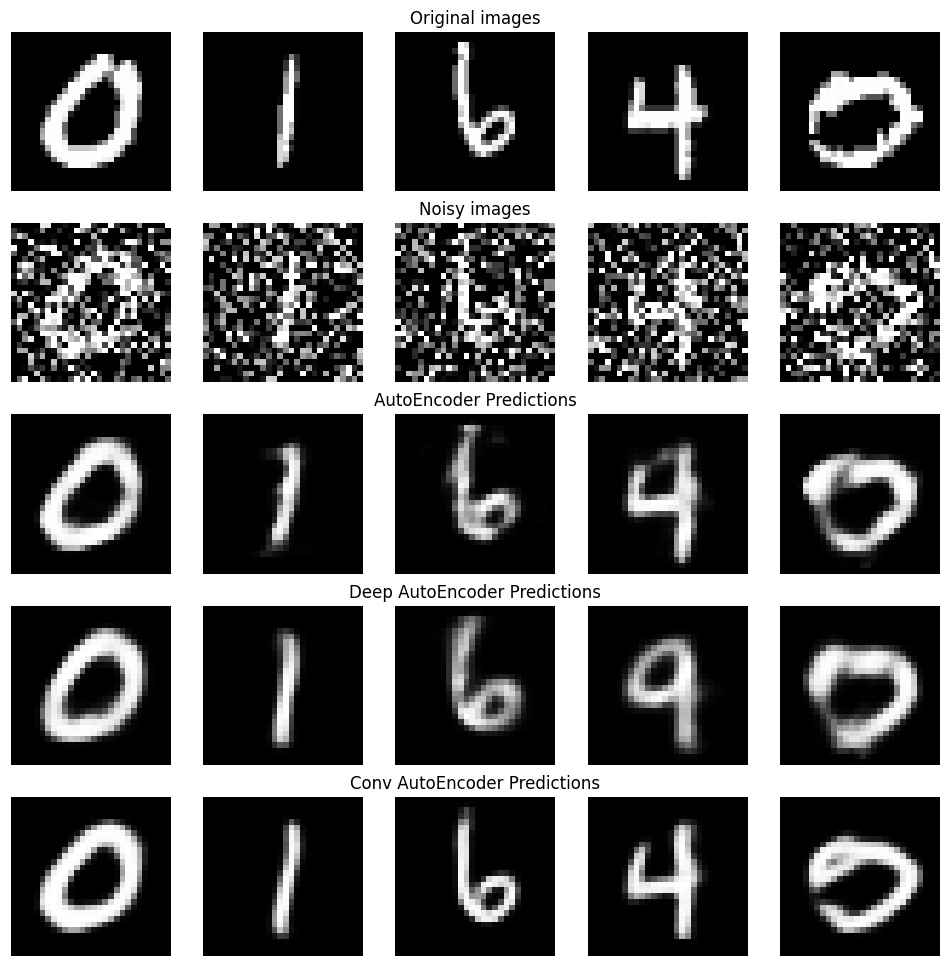

In [ ]:
inference_m(ae_128, dae_128, cae_128, sample_index, x_test_r, x_test_r_n, x_test_nn)